# Introduction

## Project Background

**Objective:** Optimize BIDMC’s resourcing strategy by understand how intake factors can predict hospital Length of Stay (LOS) 

**Data Sources:** 
* Database: https://physionet.org/content/mimiciii/1.4/
* Data Info: https://mimic.physionet.org/mimictables/callout/
* Wiki for ICD9 Codes:  https://en.wikipedia.org/wiki/List_of_ICD-9_codes_001%E2%80%93139:_infectious_and_parasitic_diseases

**Featured Techniques**
* EDA
* Feature Engineering
* Linear Regression

**Definitions:**
* Length of Stay (LOS): Amount of time spent in the hospital from admission time to discharge time
* ICD9_codes: 5 digit code that identifies each diagnoses

**Time Shifting as Defined by MIMIC-III**:   
"All dates in the database have been shifted to protect patient confidentiality. Dates will be internally consistent for the same patient, but randomly distributed in the future. This means that if measurement A is made at 2150-01-01 14:00:00, and measurement B is made at 2150-01-01 15:00:00, then measurement B was made 1 hour after measurement A.

The date shifting preserved the following:

Time of day - a measurement made at 15:00:00 was actually made at 15:00:00 local standard time.
Day of the week - a measurement made on a Sunday will appear on a Sunday in the future.
Seasonality - a measurement made during the winter months will appear during a winter month.
The date shifting removed the following:

Year - The year is randomly distributed between 2100 - 2200.
Day of the month - The absolute day of the month is not preserved.
Inter-patient information - Two patients in the ICU on 2150-01-01 were not in the ICU at the same time.
Dates of birth"

## Packages

In [ ]:
from importing_data import import_data
from initial_data_clean import add_cols_remove_rows
from consolidate_icd9_codes import compress_icd9_codes
from plotting import hist_plots, bar_plots, boxplots, lineplots
from model_implementation import dummy_cat_cols, splitting_test_and_train, linear_regression_no_cv, cross_val_testing_lr, SM_OLS_cv, SM_OLS_no_cv
from feature_engineering import all_feature_engineering, age_to_cat

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

# Importing and Cleaning Data

## Importing Data

In [ ]:
def import_files(file_name):
    """Reads in all CSV files and converts them to dataframes"""
    imported_file = pd.read_csv(f'full_data/{file_name}.csv')
    print(f"{file_name}.csv was imported")
    return imported_file

def creating_dataframe(admission, patients, diagnosis, services, icu):
    """Takes in individual dataframes and combines them on common columns"""
    adm = import_files(admission)
    pat = import_files(patients)
    diag = import_files(diagnosis)
    serv = import_files(services)
    icu = import_files(icu)
    print("All files loaded")
    return adm, pat, diag, serv, icu

def cleaning_column_names(data):
    data.columns = data.columns.str.strip().str.lower()
    return data

def merging_data(adm, pat, diag, serv, icu):
    """Merges all data frames on pre-identified columns: 'subject_id' and
    'hadm_id'."""
    raw_data = adm.merge(pat, how='outer', on='subject_id')
    raw_data = raw_data.merge(diag, how='outer', on=('subject_id', 'hadm_id'))
    raw_data = raw_data.merge(serv, how='outer', on=('subject_id', 'hadm_id'))
    raw_data = raw_data.merge(icu, how='outer', on=('subject_id', 'hadm_id'))
    print("All files were merged.")
    return raw_data

def selecting_columns(data):
    """Selects only relevant columns from the dataframe"""
    keeping_cols = ['subject_id',
                'hadm_id',
                'admittime',
                'dischtime',
                'admission_type',
                'admission_location',
                'insurance',
                'religion',
                'marital_status',
                'ethnicity',
                'gender',
                'dob',
                'deathtime',
                'icd9_code',
                'curr_service',
                "first_careunit"
               ]
    raw_data = data[keeping_cols]
    print("Appropriate columns were selected.")
    return raw_data

def import_data():
    """imports and merges 5 datasets: admissions, patients, diagnoses,
    services, and icustays."""
    adm, pat, diag, serv, icu = creating_dataframe('admissions_data', 'patient_data', 'diagnoses_icd_data', 'services_data', 'icustays')
    adm_c = cleaning_column_names(adm)
    pat_c = cleaning_column_names(pat)
    diag_c = cleaning_column_names(diag)
    serv_c = cleaning_column_names(serv)
    icu_c = cleaning_column_names(icu)
    merged_data = merging_data(adm_c, pat_c, diag_c, serv_c, icu_c)
    raw_data_selected_cols = selecting_columns(merged_data)
    print("Files imported.")
    print("Columns selected.")
    return raw_data_selected_cols

In [2]:
# Call import_data in .py file to import 5 CSV files 
raw_data = import_data()

admissions_data.csv was imported
patient_data.csv was imported
diagnoses_icd_data.csv was imported
services_data.csv was imported
icustays.csv was imported
All files loaded
All files were merged.
Appropriate columns were selected.
Files imported.
Columns selected.


In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 853619 entries, 0 to 853618
Data columns (total 16 columns):
subject_id            853619 non-null int64
hadm_id               853619 non-null int64
admittime             853619 non-null object
dischtime             853619 non-null object
admission_type        853619 non-null object
admission_location    853619 non-null object
insurance             853619 non-null object
religion              849805 non-null object
marital_status        778707 non-null object
ethnicity             853619 non-null object
gender                853619 non-null object
dob                   853619 non-null object
deathtime             112472 non-null object
icd9_code             853572 non-null object
curr_service          853307 non-null object
first_careunit        2393 non-null object
dtypes: int64(2), object(14)
memory usage: 110.7+ MB


## Creating and Removing Columns

Actions below are taken prior to any EDA. 
1. Create LOS column: leveraging admission and discharge times, creating a column to indicate length of stay, which will be the dependent variable
2. Create age column: leveraging admission and dob, creating age column as an additional feature
3. Remove dead patients: predicting death is a separate project that cannot be considered as part of this model
4. Isolate to only first-time patients: dataset includes repeat visitors which introduces auto-correlation errors. For simplicity, modeling LOS only for first-time visits. 
5. Drop all nulls: dataset is large enough to simply drop nulls rather than finding a replacement method

In [ ]:
def add_los_columns(data):
    """Adds a new column to indicate length of stay in the hospital by
    subtracting the patient's admission time from their discharge time.
    Removes outliers in the data above 2 standard deviations.
    """
    data['los'] = (pd.to_datetime(data.dischtime) - pd.to_datetime(data.admittime)).dt.total_seconds()/86400
    data = data.drop(columns=['dischtime'])
    print("Length of stay column was added.")
    return data

def creating_age_column(data):
    """Creates an age column by subtracting the patient's date of birth from their admittime.
    Then removes any ages greater than 105 which are caused by a date adjustment error (see note).
    Note: for each user, dates have been modified by a random number of years. The modification
    number of years is consistent within a patient's listings accross all columns.
    """
    data['age'] = (pd.to_datetime(data.admittime).dt.date - pd.to_datetime(data.dob).dt.date)
    data['age'] = data['age'].apply(lambda x: round(x.days / 365,0))
    data = data[data.age < 105]
    data = data.drop(columns='dob')
    print("Age column was added.")
    print("DOB column was dropped")
    return data

def removing_dead_subjects(data):
    """Removes all subjects that died while in the hospital as their length of stay is
    not indicative of a standard patient's LOS"""
    data = data[data.deathtime.isna()]
    data = data.drop(columns = ['deathtime'])
    print("Patients who died in the hospital were removed.")
    return data

def isolating_firsts(data):
    """isolates rows to only the first visit for each patient to remove
    any autocorrelatino impact."""
    grp_by_first_vis = data.groupby(['subject_id', 'hadm_id'])['admittime'].agg(['first']).reset_index()
    firsts_visits = grp_by_first_vis.merge(data, how='left', on=('subject_id', 'hadm_id'))
    print('Data isolated to first time visits only')
    firsts_visits = firsts_visits.drop(columns=['admittime', 'first'])
    return firsts_visits

def drop_nulls(data):
    """removes all rows with null values from the dataset"""
    data.first_careunit = data.first_careunit.fillna('not_admitted')
    null_dropped_data = data.dropna()
    print('Null values dropped.')
    return null_dropped_data

def add_cols_remove_rows(data):
    los_added = add_los_columns(data)
    add_age = creating_age_column(los_added)
    removed_daed = removing_dead_subjects(add_age)
    first_visits = isolating_firsts(removed_daed)
    null_dropped = drop_nulls(first_visits)
    return null_dropped

In [4]:
clean_data = add_cols_remove_rows(raw_data)

Length of stay column was added.
Age column was added.
DOB column was dropped
Patients who died in the hospital were removed.
Data isolated to first time visits only
Null values dropped.


## Consolidating ICD9 Codes

ICD9_codes indicate specific diagnoses. The first three digits indicate the broader group of diagnoses and the last two digits indicate a specific condition. For example 3 digit codes 712 indicate crystal anthropathies and 712.3 indicates chondracalcinosis, a specific type of crystal anthropathies.  

For this analysis, the 6,000+ icd9 codes were broken into 17 broader categories defined on wikipedia: https://en.wikipedia.org/wiki/List_of_ICD-9_codes_001%E2%80%93139:_infectious_and_parasitic_diseases

In [ ]:
def nummify_supplemental_icd9_codes(data):
    """converts all icd9 codes that start with a letter to a number in order
    to use number ranges to identify diagnoes."""
    data.icd9_code = data.icd9_code.apply(lambda x: '.1' if 'V' in x else x)
    data.icd9_code = data.icd9_code.apply(lambda x: '.8' if 'M' in x else x)
    data.icd9_code = data.icd9_code.apply(lambda x: '.5' if 'E' in x else x)
    data.icd9_code = data.icd9_code.apply(lambda x: x[:3] if ('E' not in x) & ('M' not in x) & ('V' not in x)else x)

    data.icd9_code = data.icd9_code.astype(float)
    print("Supplemental codes turned into floats")
    return data

def f(row):
    """assigned a diagnoses string to each icd9_code value. Returns a string
    value to replace the icd9_code with."""
    if 1 <= row['icd9_code'] <= 139:
        val = 'Parasitic_Disease'
    elif 140 <= row['icd9_code'] <= 239:
        val = 'Neoplasm'
    elif 240 <= row['icd9_code'] <= 279:
        val = 'Endocrine'
    elif 280 <= row['icd9_code'] <= 289:
        val = "Blood"
    elif 290 <= row['icd9_code'] <= 319:
        val = "Mental_Disorder"
    elif 320 <= row['icd9_code'] <= 389:
        val = "Nervous_System"
    elif 390 <= row['icd9_code'] <= 459:
        val = "Circulatory_System"
    elif 460 <= row['icd9_code'] <= 519:
        val = "Respiratory_System"
    elif 520 <= row['icd9_code'] <= 579:
        val = "Digestive_System"
    elif 580 <= row['icd9_code'] <= 629:
        val = "Genitourinary_System"
    elif 630 <= row['icd9_code'] <= 679:
        val = "Pregnancy"
    elif 680 <= row['icd9_code'] <= 709:
        val = "Skin"
    elif 710 <= row['icd9_code'] <= 739:
        val = "Musculoskeletal"
    elif 740 <= row['icd9_code'] <= 759:
        val = "Congenital_Anomalies"
    elif 760 <= row['icd9_code'] <= 779:
        val = "Perinatal"
    elif 780 <= row['icd9_code'] <= 799:
        val = "Ill-Defined"
    elif 800 <= row['icd9_code'] <= 999:
        val = "Injury/Poison"
    elif row['icd9_code'] < .4:
        val = "Supplemental_factors"
    elif .4 <= row['icd9_code'] < .7:
        val = "External_Cause_Inj_Poison"
    elif .7 <= row['icd9_code'] < .9:
        val = "Morphology_of_Neoplasms"
    else:
        val = row['icd9_code']
    return val

def compress_icd9_codes(data):
    """replaces the 6000 unique ICD9_code column with 17 diagnoses,
    in a new column, 'diagnoses'."""
    all_numified = nummify_supplemental_icd9_codes(data)
    all_numified['diagnoses'] = all_numified.apply(f, axis=1)
    compressed_icd9 = all_numified.drop(columns=['icd9_code'])
    print("ICD9 codes truncated to 17 categories")
    return compressed_icd9

In [8]:
clean_data = compress_icd9_codes(clean_data)

Supplemental codes turned into floats
ICD9 codes truncated to 17 categories


In [10]:
clean_data.diagnoses.value_counts()

Circulatory_System           148577
Endocrine                     73669
Supplemental_factors          56121
Respiratory_System            44343
Injury/Poison                 44275
Digestive_System              39962
Genitourinary_System          33673
Ill-Defined                   30782
Blood                         27629
Mental_Disorder               25874
External_Cause_Inj_Poison     24848
Nervous_System                24411
Parasitic_Disease             20539
Neoplasm                      16893
Musculoskeletal               14868
Skin                           9444
Congenital_Anomalies           2157
Pregnancy                      1520
Perinatal                       666
Name: diagnoses, dtype: int64

In [11]:
clean_data.to_pickle(path='clean_data')

In [2]:
clean_data = pd.read_pickle('clean_data')

# Exploratory Data Analysis

In [4]:
# Plotting helper functions
bidmc_deep_blue = '#283891'

def hist_plots(column, title, xaxis, yaxis, save=False, rotate=False):

    plt.figure(figsize=(10,5))
    plt.hist(column, color=bidmc_deep_blue, bins=50)

    plt.title(title, fontsize=18)
    plt.ylabel(xaxis, fontsize=14)
    plt.xlabel(yaxis, fontsize=14);

    if rotate:
        plt.xticks(rotation=45, ha='right')

    if save:
        plt.savefig(title + '.png')
    return

def bar_plots(x, y, title, xaxis, yaxis, order=None, save=False, rotate=False):
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x =x, y=y, color=bidmc_deep_blue, order=order);

    ax.set_title(title, fontsize=18)
    ax.set_ylabel(xaxis, fontsize=14)
    ax.set_xlabel(yaxis, fontsize=14);
    sns.despine()

    if rotate:
        plt.xticks(rotation=45, ha='right')

    if save:
        plt.savefig(title + '.png')
    return

def boxplots(x, y, title, xaxis, yaxis, order=None, save=False, rotate=False):
    plt.figure(figsize=(10,5))
    ax = sns.boxplot(x=x, y=y, color='white', order=order, showfliers=False);

    ax.set_title(title, fontsize=18)
    ax.set_ylabel(xaxis, fontsize=14)
    ax.set_xlabel(yaxis, fontsize=14);
    sns.despine()

    if rotate:
        plt.xticks(rotation=45, ha='right')

    if save:
        plt.savefig(title + '.png')
    return

def lineplots(x, y, title, xaxis, yaxis, save=False, rotate=False):
    plt.figure(figsize=(10,5))
    ax = sns.lineplot(x=x, y=y);

    ax.set_title(title, fontsize=18)
    ax.set_ylabel(xaxis, fontsize=14)
    ax.set_xlabel(yaxis, fontsize=14);
    sns.despine()

    if rotate:
        plt.xticks(rotation=45, ha='right')

    if save:
        plt.savefig(title + '.png')
    return

## Length of Stay

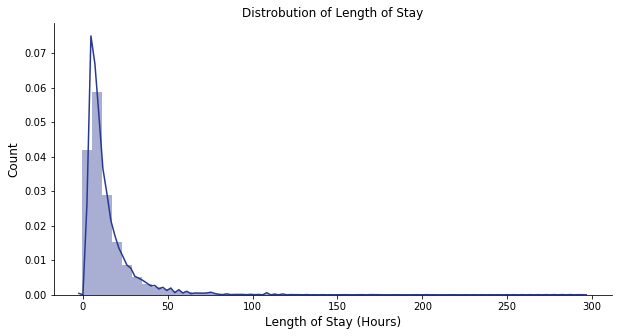

In [13]:
def plt_los():
    plt.figure(figsize=(10,5))
    los_distro = sns.distplot(clean_data.los, color=bidmc_deep_blue)

    los_distro.set_title('Distrobution of Length of Stay', fontsize=12)
    los_distro.set_ylabel('Count', fontsize=12)
    los_distro.set_xlabel('Length of Stay (Hours)', fontsize=12);
    sns.despine()
    
plt_los()

Accuracy of the model has drastically different impact on short vs longterm hospital stays. A patient is considered in long-term care if they stay over 30 days sos this model will focus on patients staying <30 days.

In [14]:
#focusing model on only short-term stays
clean_data = clean_data[clean_data.los <= 30]
clean_data = clean_data[clean_data.los > 0]

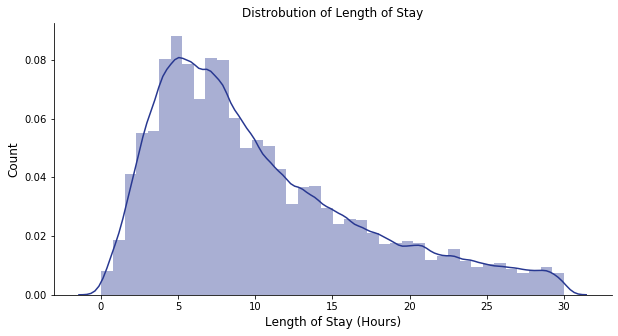

In [15]:
plt_los()

## Admission Type

Because all columns are categorical, pairplot and heatmap are not sufficient for analyzing correlations. Instead, each feature is plotted against length of stay and assessed individually.

In [16]:
#grouping by hadm_id to ensure each visit is counted individually 
grped_per_vis = clean_data.groupby('hadm_id').max().reset_index()

In [17]:
grped_per_vis.admission_type.unique()

array(['EMERGENCY', 'ELECTIVE', 'URGENT', 'NEWBORN'], dtype=object)

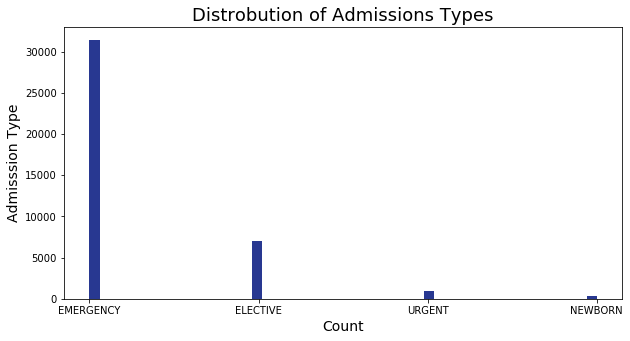

In [18]:
hist_plots(grped_per_vis.admission_type, 'Distrobution of Admissions Types', xaxis='Admisssion Type', yaxis='Count')

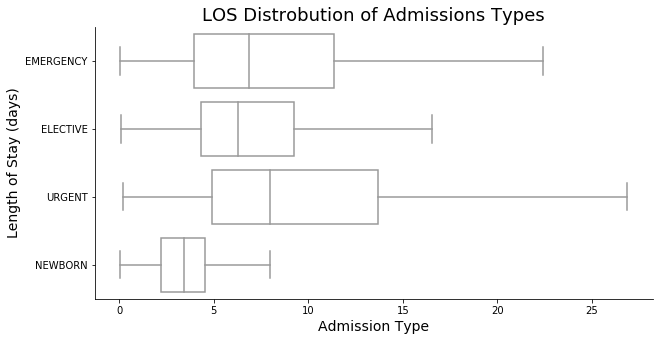

In [19]:
boxplots(x=grped_per_vis.los, y=grped_per_vis.admission_type, title='LOS Distrobution of Admissions Types', xaxis='Length of Stay (days)', yaxis='Admission Type')

## Admission Location

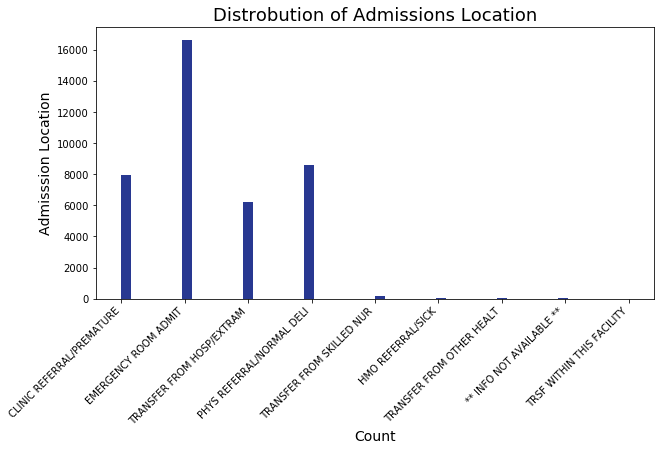

In [20]:
hist_plots(grped_per_vis.admission_location, 'Distrobution of Admissions Location', xaxis='Admisssion Location', yaxis='Count', rotate=True)

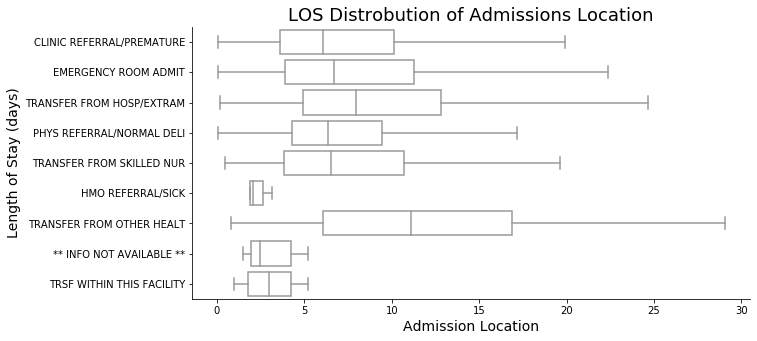

In [21]:
boxplots(x=grped_per_vis.los, y=grped_per_vis.admission_location, title='LOS Distrobution of Admissions Location', xaxis='Length of Stay (days)', yaxis='Admission Location')

## Insurance

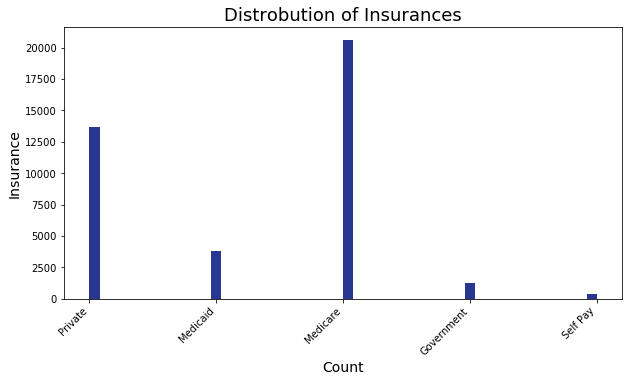

In [22]:
hist_plots(grped_per_vis.insurance, 'Distrobution of Insurances', xaxis='Insurance', yaxis='Count', rotate=True)

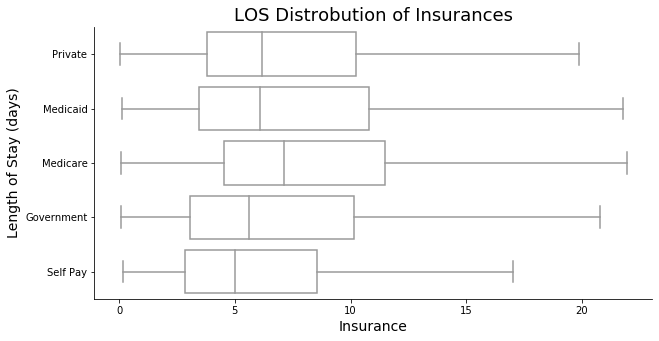

In [23]:
boxplots(x=grped_per_vis.los, y=grped_per_vis.insurance, title='LOS Distrobution of Insurances', xaxis='Length of Stay (days)', yaxis='Insurance')

## Relgion

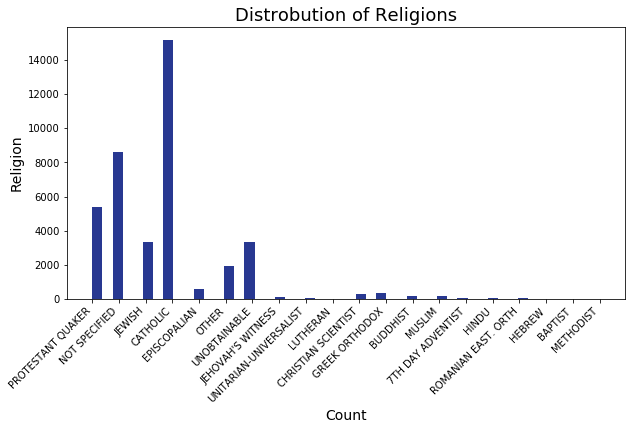

In [24]:
hist_plots(grped_per_vis.religion, 'Distrobution of Religions', xaxis='Religion', yaxis='Count', rotate=True)

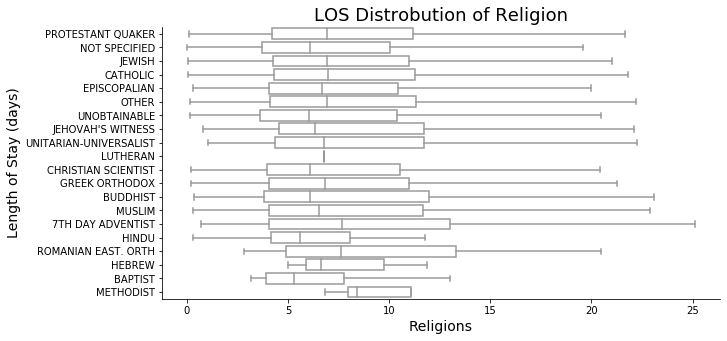

In [25]:
boxplots(x=grped_per_vis.los, y=grped_per_vis.religion, title='LOS Distrobution of Religion', xaxis='Length of Stay (days)', yaxis='Religions')

## Marital Status

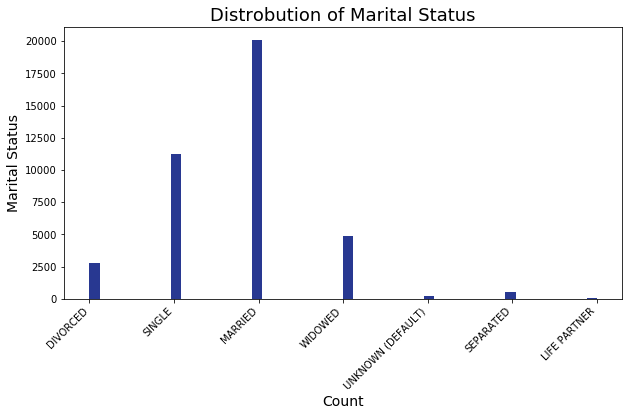

In [26]:
hist_plots(grped_per_vis.marital_status, 'Distrobution of Marital Status', xaxis='Marital Status', yaxis='Count', rotate=True)

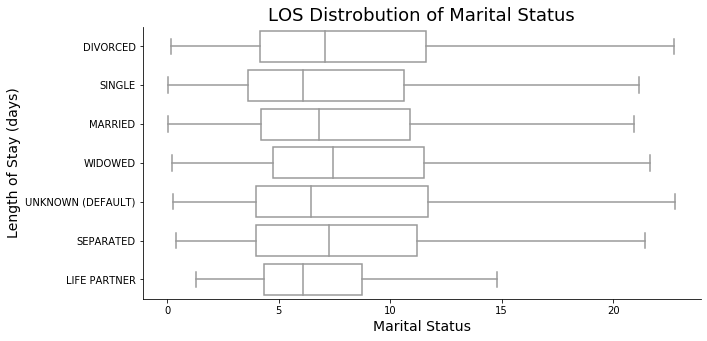

In [27]:
boxplots(x=grped_per_vis.los, y=grped_per_vis.marital_status, title='LOS Distrobution of Marital Status', xaxis='Length of Stay (days)', yaxis='Marital Status')

## Ethnicity

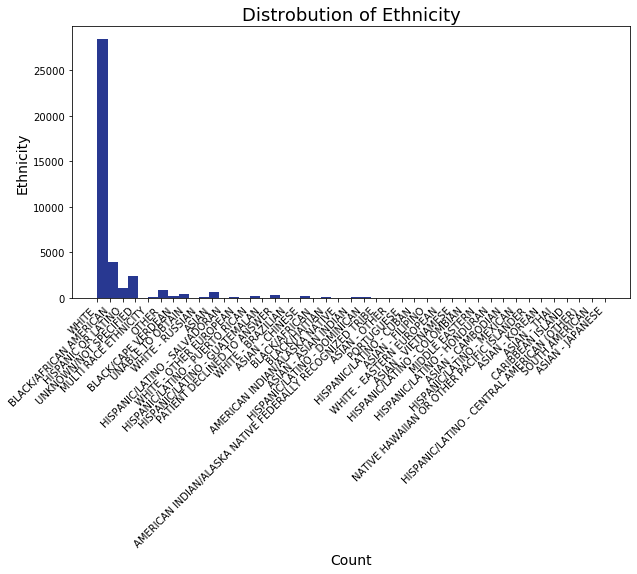

In [28]:
hist_plots(grped_per_vis.ethnicity, 'Distrobution of Ethnicity', xaxis='Ethnicity', yaxis='Count', rotate=True)

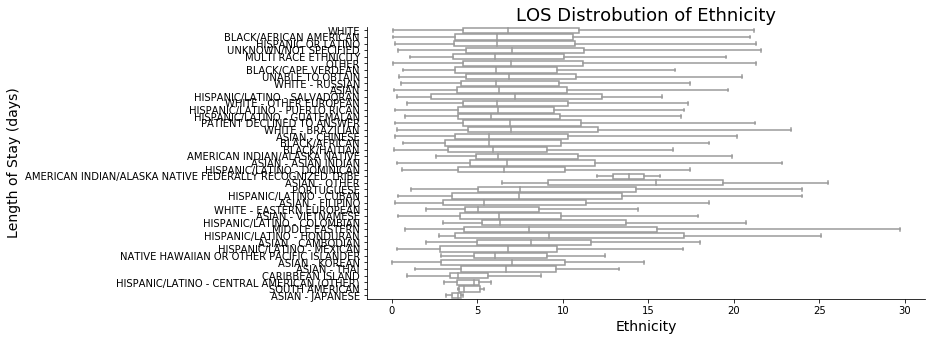

In [29]:
boxplots(x=grped_per_vis.los, y=grped_per_vis.ethnicity, title='LOS Distrobution of Ethnicity', xaxis='Length of Stay (days)', yaxis='Ethnicity')

## Gender

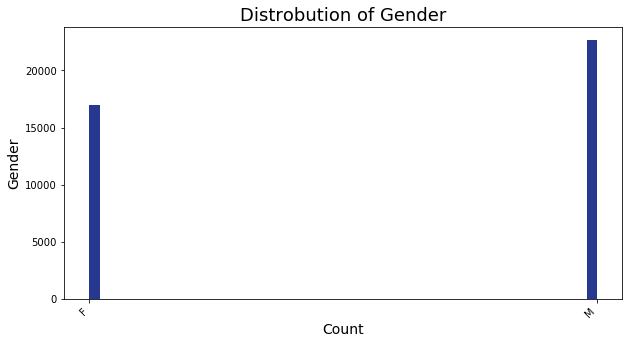

In [30]:
hist_plots(grped_per_vis.gender, 'Distrobution of Gender', xaxis='Gender', yaxis='Count', rotate=True)

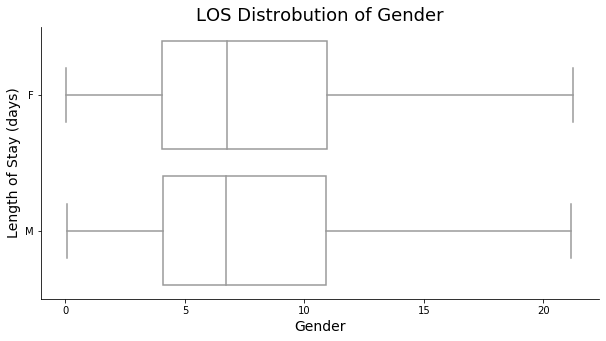

In [31]:
boxplots(x=grped_per_vis.los, y=grped_per_vis.gender, title='LOS Distrobution of Gender', xaxis='Length of Stay (days)', yaxis='Gender')

## ICD9 Codes

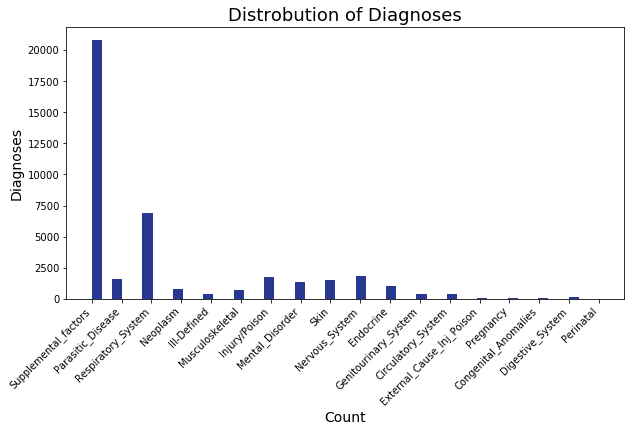

In [32]:
hist_plots(grped_per_vis.diagnoses, 'Distrobution of Diagnoses', xaxis='Diagnoses', yaxis='Count', rotate=True)

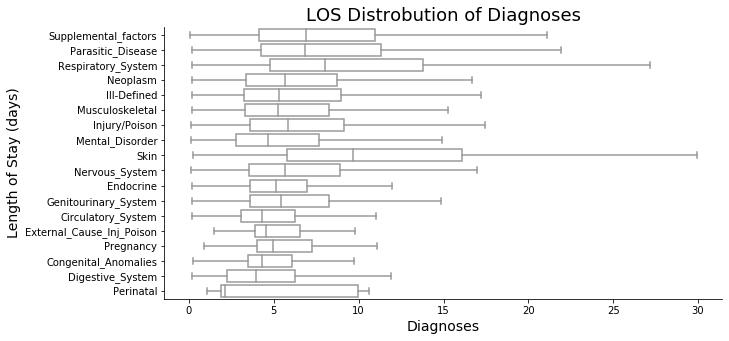

In [33]:
boxplots(x=grped_per_vis.los, y=grped_per_vis.diagnoses, title='LOS Distrobution of Diagnoses', xaxis='Length of Stay (days)', yaxis='Diagnoses')

## Current Service

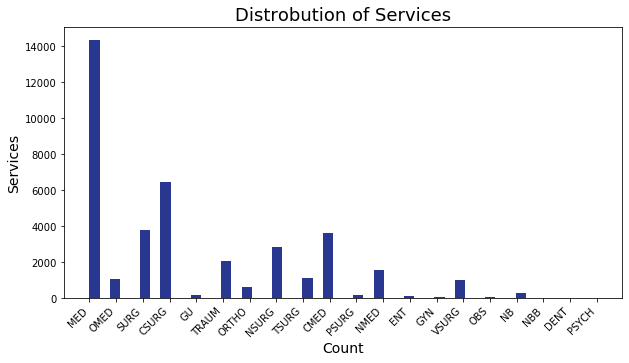

In [34]:
hist_plots(grped_per_vis.curr_service, 'Distrobution of Services', xaxis='Services', yaxis='Count', rotate=True)

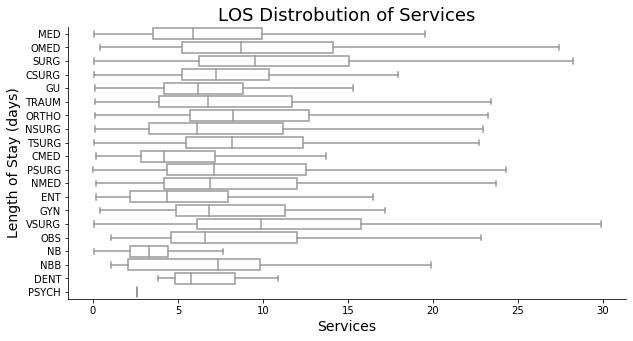

In [35]:
boxplots(x=grped_per_vis.los, y=grped_per_vis.curr_service, title='LOS Distrobution of Services', xaxis='Length of Stay (days)', yaxis='Services')

In [36]:
grped_per_vis.groupby('curr_service')['los'].mean().sort_values()

curr_service
PSYCH     2.618056
NB        4.789312
ENT       5.594659
CMED      5.743998
DENT      6.837500
GU        7.059225
MED       7.640947
NSURG     8.131640
GYN       8.211431
NBB       8.434960
CSURG     8.656229
TRAUM     8.777934
NMED      8.879655
PSURG     9.054541
OBS       9.109306
TSURG     9.607784
ORTHO     9.877142
OMED     10.643368
SURG     11.191394
VSURG    11.441032
Name: los, dtype: float64

## Age

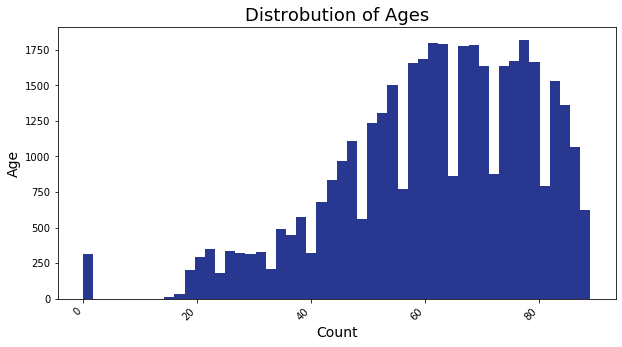

In [37]:
hist_plots(grped_per_vis.age, 'Distrobution of Ages', xaxis='Age', yaxis='Count', rotate=True)

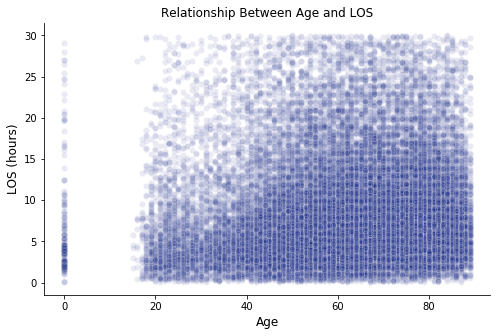

In [38]:
plt.figure(figsize=(8,5))
ethn_los = sns.scatterplot(y=grped_per_vis.los, x = grped_per_vis.age, color=bidmc_deep_blue, alpha=.1);

ethn_los.set_title('Relationship Between Age and LOS', fontsize=12)
ethn_los.set_ylabel('LOS (hours)', fontsize=12)
ethn_los.set_xlabel('Age', fontsize=12);
sns.despine()

## ICU Admittance

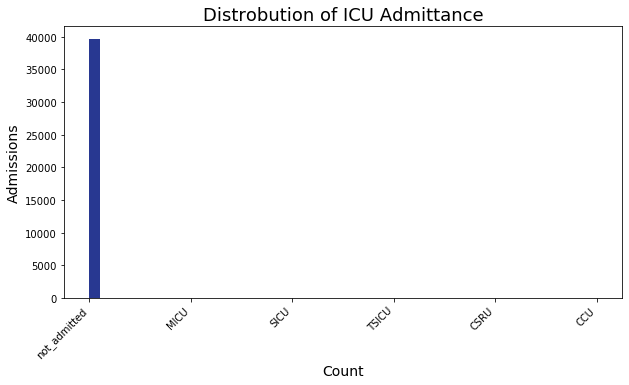

In [39]:
hist_plots(grped_per_vis.first_careunit, 'Distrobution of ICU Admittance', xaxis='Admissions', yaxis='Count', rotate=True)

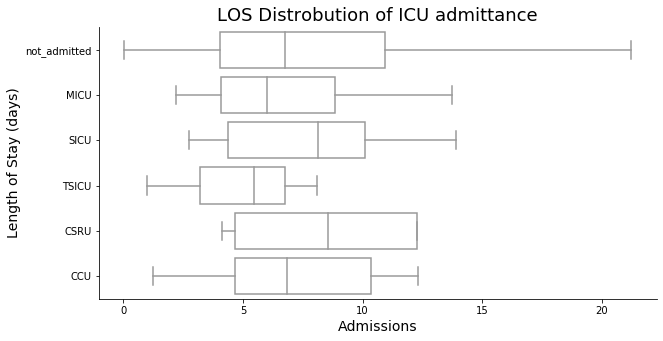

In [40]:
boxplots(x=grped_per_vis.los, y=grped_per_vis.first_careunit, title='LOS Distrobution of ICU admittance', xaxis='Length of Stay (days)', yaxis='Admissions')

# Feature Engineering

In [ ]:
def compressing_admission_type(data):
    eng_data = data
    eng_data.admission_type = eng_data.admission_type.apply(lambda x: 'EMERGENCY' if x == 'URGENT' else x)
    print("Admission type compressed.")
    return eng_data

def r(row):
    if 0 <= row['age'] <= 3:
        val = 'Baby'
    elif 3 <= row['age'] <= 18:
        val = 'Child/Teen'
    elif 19 <= row['age'] <= 40:
        val = 'Young_Aduld'
    elif 41 <= row['age'] <= 60:
        val = "Adult"
    elif 61 <= row['age'] <= 100:
        val = "Senior"
    return val


def age_to_cat(data):
    eng_data = data
    eng_data['age'] = eng_data.apply(r, axis=1)
    print("Age column compressed.")
    return eng_data

def compressing_careunit(data):
    eng_data = data
    eng_data.first_careunit = eng_data.first_careunit.apply(lambda x: 'ICU' if (x == 'MICU') | (x == 'SICU') | (x == 'CCU') | (x == 'CSRU') | (x == 'TSICU') else x)
    print("Careunit compressed.")
    return eng_data

def compressing_curr_serv(data):
    eng_data = data
    eng_data.curr_service = eng_data.curr_service.apply(lambda x: 'SURGERGY' if (x == 'CSURG') | (x == 'NSURG') | (x == 'ORTHO') | (x == 'PSURG') | (x == 'SURG') | (x == 'TSURG') | (x == 'VSURG') else x)
    eng_data.curr_service = eng_data.curr_service.apply(lambda x: "MED" if (x == 'CMED') | (x == 'OMED') | (x == 'NMED') | (x == 'TRAUM') else x)
    eng_data.curr_service = eng_data.curr_service.apply(lambda x: "GYNOCOLOGY/NEWBORN" if (x == 'NB') | (x == 'NBB') | (x == 'OBS') | (x == 'GYN') else x)
    eng_data.curr_service = eng_data.curr_service.apply(lambda x: "OTHER" if (x == "GU") | (x == "ENT") | (x == "DENT") | (x == "PSYCH") else x)
    print("Services compressed.")
    return eng_data

def compressing_ethnicity(data):
    eng_data = data
    eng_data.ethnicity = eng_data.ethnicity.apply(lambda x: 'WHITE' if ("WHITE" in x) else x)
    eng_data.ethnicity = eng_data.ethnicity.apply(lambda x: "ASIAN" if ("ASIAN" in x) else x)
    eng_data.ethnicity = eng_data.ethnicity.apply(lambda x: "HISPANIC/LATINO" if ("LATINA" in x) | ("HISPANIC" in x) else x)
    eng_data.ethnicity = eng_data.ethnicity.apply(lambda x: "OTHER/UNKNOWN" if (x=="AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE") | (x=="SOUTH AMERICAN") | (x=="CARIBBEAN ISLAND") | (x=="NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER") |(x=="AMERICAN INDIAN/ALASKA NATIVE") | (x=="MIDDLE EASTERN") | (x=="PORTUGUESE") | (x=="MULTI RACE ETHNICITY") | (x=="PATIENT DECLINED TO ANSWER") | (x=="OTHER") | ("UNKNOWN" in x) | ("OBTAIN" in x) else x)
    eng_data.ethnicity = eng_data.ethnicity.apply(lambda x: "BLACK_AFRICAN/OTHER" if ("BLACK" in x) else x)
    print("Ethnicities compressed.")
    return data

def compressing_marital_status(data):
    eng_data = data
    eng_data.marital_status = eng_data.marital_status.apply(lambda x: 'LIFE_PARTNER' if (x == 'MARRIED') | (x == 'LIFE PARTNER') else x)
    eng_data.marital_status = eng_data.marital_status.apply(lambda x: 'SINGLE' if (x == 'WIDOWED') | (x == 'DIVORCED') | (x == 'SEPARATED') else x)
    eng_data.marital_status = eng_data.marital_status.apply(lambda x: 'OTHER/UNKNOWN' if (x == 'UNKNOWN (DEFAULT)') else x)
    print("Marital status compressed.")
    return data

def compressing_religion(data):
    eng_data = data
    eng_data.religion = eng_data.religion.apply(lambda x: 'RELIGIOUS' if (x == "LUTHERAN") | (x == "METHODIST") | (x == "HEBREW") | (x == "BAPTIST") | (x == "HINDU") | (x == "UNITARIAN-UNIVERSALIST") | (x == "ROMANIAN EAST. ORTH") | (x == "7TH DAY ADVENTIST") | (x == "JEHOVAH'S WITNESS") | (x == 'MUSLIM') | (x == 'BUDDHIST') | (x == 'CHRISTIAN SCIENTIST') | (x == 'GREEK ORTHODOX') | (x == 'EPISCOPALIAN') | (x == 'OTHER') | (x == 'JEWISH') | (x == 'CATHOLIC') | (x == 'PROTESTANT QUAKER') else x)
    print("Religion compressed.")
    return data

def compressing_admit_location(data):
    eng_data = data
    eng_data.admission_location = eng_data.admission_location.apply(lambda x: 'ER_ADMIT' if (x == 'EMERGENCY ROOM ADMIT ') else x)
    eng_data.admission_location = eng_data.admission_location.apply(lambda x: 'REFERRAL' if (x == 'HMO REFERRAL/SICK') | (x == 'PHYS REFERRAL/NORMAL DELI') | (x == 'CLINIC REFERRAL/PREMATURE') else x)
    eng_data.admission_location = eng_data.admission_location.apply(lambda x: 'TRANSFER' if (x == 'TRANSFER FROM HOSP/EXTRAM') | (x == 'TRANSFER FROM SKILLED NUR') | (x == 'TRANSFER FROM OTHER HEALT') | (x == 'TRSF WITHIN THIS FACILITY')else x)
    eng_data.admission_location = eng_data.admission_location.apply(lambda x: 'OTHER/UNKNOWN' if (x == '** INFO NOT AVAILABLE **')  else x)
    print("Admissiong location compressed.")
    print("Done compressing.")
    return eng_data

def all_feature_engineering(data):
    fe_data = compressing_admission_type(data)
    fe_data = age_to_cat(fe_data)
    fe_data = compressing_careunit(fe_data)
    fe_data = compressing_curr_serv(fe_data)
    fe_data = compressing_ethnicity(fe_data)
    fe_data = compressing_marital_status(fe_data)
    fe_data = compressing_religion(fe_data)
    fe_data = compressing_admit_location(fe_data)

    return fe_data

In [ ]:
consolidated_variables_data = all_feature_engineering(clean_data)

# Model Development

Model tuning was performed usig a 10 fold cross-validation. Model variations are stored in prior iteration of the document. Model comparisons and the final output are shown below. 

In [ ]:
def dummy_cat_cols(data):
    """Creates dummy variables for each categorical column.
    Groups the rows by admission event (hadm_id) so that each admission event is a single row
    with a recording for each diagnoses recieved during that admission event. Each admission
    event can have multiple diagnoses. Drops subject_id and hadm_id which are no longer needed."""
    #cat_cols = ['admission_type', 'admission_location', 'insurance', 'religion', 'marital_status', 'ethnicity', 'gender', 'curr_service', 'diagnoses']
    cat_cols = [col for col in data.columns if (data[col].dtype == 'O')]

    dummied_data = pd.get_dummies(data, drop_first=True, columns=cat_cols)

    #groups the rows so that each admission is a single row and the diagnoses are summed for that admission
    grouped_dummy_data = dummied_data.groupby('hadm_id').max().reset_index()
    select_cols = grouped_dummy_data.drop(columns = ['subject_id', 'hadm_id'])

    print("Dummy variables created.")

    return select_cols


def splitting_test_and_train(data, t_size=.2):
    """Separates data into X and y. Splits the data into test and train data for holdout testing."""
    X, y = data.drop('los', axis=1), data['los']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size, random_state=10) #hold out 20% of the data for final testing

    #this helps with the way kf will generate indices below
    print("Train and test data are separated")

    return X_train, X_test, y_train, y_test


def cross_val_testing_lr(X_train, X_test, y_train, y_test):
    """Within the 80% train data, splits the model into 10 folds for cross-validation testing.
    Runs a linear regression on the train and validation data without standard scaling as all
    factors are categorical other than age. Prints R^2, RMSE, and MAE for in and out of sample
    predictions."""

    kf = KFold(n_splits=10, shuffle=True, random_state = 71)

    cv_lm_r2s, in_sample_r2s = [], [] #collect the validation results for both models
    cv_lm_rmse, in_sample_rmses = [], []
    cv_lm_mae, in_sample_mae = [], []

    print("Kfolds created. Running linear regression.")

    for train_ind, val_ind in kf.split(X_train,y_train):

        X_tr, y_tr = X_train.iloc[train_ind], y_train.iloc[train_ind]
        X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]

        #defining simple linear regression
        lm = LinearRegression()
        lm.fit(X_tr, y_tr)
        in_sample_predict = lm.predict(X_tr)
        out_of_sample_predict = lm.predict(X_val)

        cv_lm_r2s.append(lm.score(X_val, y_val))
        in_sample_r2s.append(lm.score(X_tr, y_tr))

        cv_lm_rmse.append(np.sqrt(mean_squared_error(y_val, out_of_sample_predict)))
        in_sample_rmses.append(np.sqrt(mean_squared_error(y_tr, in_sample_predict)))

        cv_lm_mae.append(mean_absolute_error(y_val, out_of_sample_predict))
        in_sample_mae.append(mean_absolute_error(y_tr, in_sample_predict))

        mean_r2 = float(np.mean(cv_lm_r2s))
        mean_rmse = float(np.mean(cv_lm_rmse))
        mean_mae = float(np.mean(in_sample_mae))

    print('\nLinear regression scores r^2: ', cv_lm_r2s, '\n')
    print(f'Linear regression mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}\n')
    print(f"Mean r^2 for in sample data: {np.mean(in_sample_r2s):.3f} +- {np.std(in_sample_r2s):.3f} \n\n")

    print('Linear regression scores rmse: ', cv_lm_rmse, '\n')
    print(f'Linear regression mean cv rmse: {np.mean(cv_lm_rmse):.3f} +- {np.std(cv_lm_rmse):.3f}\n')
    print(f"Mean rmse for in sample data: {np.mean(in_sample_rmses):.3f} +- {np.std(in_sample_rmses):.3f}")

    print('Linear regression scores mae: ', cv_lm_mae, '\n')
    print(f'Linear regression mean cv mae: {np.mean(cv_lm_mae):.3f} +- {np.std(cv_lm_mae):.3f}\n')
    print(f"Mean mae for in sample data: {np.mean(in_sample_mae):.3f} +- {np.std(in_sample_mae):.3f}")

    return mean_r2, mean_rmse, mean_mae

## Comparing Models

In [72]:
r2_scores = r21, r22, r23, r24, r25, r26
mae_scores = rmse1, rmse2, rmse3, rmse4, rmse5, rmse6
rmse_scores = mae1, mae2, mae3, mae4, mae5, mae6

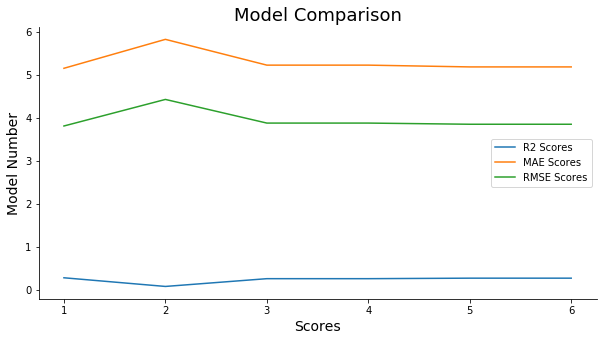

In [73]:
x = list(range(1,7))
lineplots(x, y=r2_scores, title='Model Comparison', xaxis='Model Number', yaxis='Scores')
sns.lineplot(x, y=mae_scores)
sns.lineplot(x, y=rmse_scores)
plt.legend(labels=['R2 Scores', 'MAE Scores', 'RMSE Scores'])

# Final Model Implementation

First model proved to be the strongest model, final testing will be done using that model.

In [ ]:
def linear_regression_no_cv(X_train, X_test, y_train, y_test):
    """Runs linear regression without cross-validation for final model implementation on
    holdout dataset. Returns in-sample and out of sampel R^2, RMSE, and MAE. """
    cv_lm_r2s, in_sample_r2s = [], [] #collect the validation results for both models
    cv_lm_rmse, in_sample_rmses = [], []
    cv_lm_mae, in_sample_mae = [], []

    #defining simple linear regression
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    in_sample_predict = lm.predict(X_train)
    out_of_sample_predict = lm.predict(X_test)

    cv_lm_r2s.append(lm.score(X_test, y_test))
    in_sample_r2s.append(lm.score(X_train, y_train))

    cv_lm_rmse.append(np.sqrt(mean_squared_error(y_test, out_of_sample_predict)))
    in_sample_rmses.append(np.sqrt(mean_squared_error(y_train, in_sample_predict)))

    cv_lm_mae.append(mean_absolute_error(y_test, out_of_sample_predict))
    in_sample_mae.append(mean_absolute_error(y_train, in_sample_predict))


    print('\nLinear regression score r^2: ', cv_lm_r2s, '\n')
    print('\nIn sample linear regression score r^2: ', in_sample_r2s, '\n')


    print('Linear regression scores rmse: ', cv_lm_rmse, '\n')
    print('In sample linear regression scores rmse: ', in_sample_rmses, '\n')

    print('Linear regression scores mae: ', cv_lm_mae, '\n')
    print('In sample linear regression scores mae: ', in_sample_mae, '\n')

    return out_of_sample_predict


def SM_OLS_cv(X_train, X_test, y_train, y_test):
    """Splits data into 10 folds for cross-validation OLS. Performs OLS
    and returns the result summary."""

    #adds column of ones for B_0 constant coefficient
    X_train = add_constant(X_train)
    kf = KFold(n_splits=10, shuffle=True, random_state = 71)
    print("Kfolds created. Running OLS.")

    for train_ind, val_ind in kf.split(X_train,y_train):

        X_tr, y_tr = X_train.iloc[train_ind], y_train.iloc[train_ind]
        X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]

        #Running OLS
        los_model = sm.OLS(y_tr, X_tr)
        results = los_model.fit()
    print("OLS run. Result summary returned.")

    return results.summary()

def SM_OLS_no_cv(X_train, X_test, y_train, y_test):
    """Runs OLS without cross-validation for final, hold out dataset OLS
    model implementation. Returns results summary."""

    #adds column of ones for B_0 constant coefficient
    X_train = add_constant(X_train)

    #Running OLS
    los_model = sm.OLS(y_train, X_train)
    results = los_model.fit()

    return results.summary()


In [74]:
X_train_fm, X_test_fm, y_train_fm, y_test_fm = splitting_test_and_train(baseline_dummied_v1)
full_dataset_regression_predictions = linear_regression_no_cv(X_train_fm, X_test_fm, y_train_fm, y_test_fm)

Train and test data are separated

Linear regression score r^2:  [0.28013062931193644] 


In sample linear regression score r^2:  [0.28268819219747676] 

Linear regression scores rmse:  [5.064557854515229] 

In sample linear regression scores rmse:  [5.129225179102363] 

Linear regression scores mae:  [3.7513560994530706] 

In sample linear regression scores mae:  [3.8099508247897855] 



In [75]:
final_sm_no_cv = SM_OLS_no_cv(X_train_fm, X_test_fm, y_train_fm, y_test_fm)
final_sm_no_cv

/Users/mollyliebeskind/opt/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    los   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     100.5
Date:                Sun, 26 Jan 2020   Prob (F-statistic):               0.00
Time:                        09:49:27   Log-Likelihood:                -96976.
No. Observations:               31755   AIC:                         1.942e+05
Df Residuals:                   31630   BIC:                         1.952e+05
Df Model:                         124                                         
Covariance Type:            nonrobust                                         
======================================================================================================================================
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------
const                                                                 -2.3219      2.962     -0.784      0.433      -8.127       3.483
age                                                                    0.0026      0.003      0.937      0.349      -0.003       0.008
admission_type_EMERGENCY                                               2.1033      0.180     11.717      0.000       1.751       2.455
admission_type_NEWBORN                                                 2.0736      2.465      0.841      0.400      -2.758       6.905
admission_type_URGENT                                                  2.8842      0.235     12.295      0.000       2.424       3.344
admission_location_CLINIC REFERRAL/PREMATURE                          -0.0182      1.487     -0.012      0.990      -2.933       2.896
admission_location_EMERGENCY ROOM ADMIT                                1.1033      1.487      0.742      0.458      -1.811       4.017
admission_location_HMO REFERRAL/SICK                                  -1.0480      2.544     -0.412      0.680      -6.034       3.938
admission_location_PHYS REFERRAL/NORMAL DELI                           1.4573      1.479      0.985      0.325      -1.442       4.357
admission_location_TRANSFER FROM HOSP/EXTRAM                           1.8920      1.487      1.272      0.203      -1.023       4.807
admission_location_TRANSFER FROM OTHER HEALT                           2.2393      1.727      1.296      0.195      -1.146       5.625
admission_location_TRANSFER FROM SKILLED NUR                          -0.7274      1.559     -0.467      0.641      -3.783       2.328
admission_location_TRSF WITHIN THIS FACILITY                          -0.8209      2.739     -0.300      0.764      -6.190       4.548
insurance_Medicaid                                                    -0.2231      0.190     -1.175      0.240      -0.595       0.149
insurance_Medicare                                                    -0.4608      0.182     -2.534      0.011      -0.817      -0.104
insurance_Private                                                     -0.3950      0.176     -2.243      0.025      -0.740      -0.050
insurance_Self Pay                                                    -0.8165      0.351     -2.326      0.020      -1.505      -0.128
religion_BAPTIST                                                      -1.4265      1.404     -1.016      0.310      -4.178       1.325
religion_BUDDHIST                                                     -1.2480      0.839     -1.487      0.137      -2.893       0.397
religion_CATHOLIC                                                     -1.3492      0.709     -1.903      0.057   

In [76]:
final_results_as_html = final_sm_no_cv.tables[1].as_html()
final_results_as_html_table= pd.read_html(final_results_as_html, header=0, index_col=0)[0]

final_results_columns = list(final_results_as_html_table.index)
final_results_coefs = list(final_results_as_html_table.coef)
final_results_p_vals = list(final_results_as_html_table['P>|t|'])


cols_with_coefs = list(zip(final_results_columns, final_results_coefs, final_results_p_vals))

cols_with_coefs_df = pd.DataFrame({'column': final_results_columns, 'coef': final_results_coefs, 'p_val': final_results_p_vals})

sorted_col_coef = cols_with_coefs_df[cols_with_coefs_df.p_val < .05].sort_values(by='coef', ascending=False)[:40]
sorted_col_coef = sorted_col_coef.replace({'ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE': 'ethnicity_AMER INDIAN/ALASKA NATIVE'})
sorted_col_coef

,column,coef,p_val
42,ethnicity_AMER INDIAN/ALASKA NATIVE,9.7941,0.015
50,ethnicity_ASIAN - OTHER,7.0488,0.006
101,curr_service_VSURG,4.7716,0.000
96,curr_service_PSURG,4.7023,0.000
98,curr_service_SURG,4.2763,0.000
83,curr_service_CSURG,4.2035,0.000
120,diagnoses_Perinatal,3.9735,0.000
95,curr_service_ORTHO,3.9158,0.000
93,curr_service_OBS,3.7788,0.000
92,curr_service_NSURG,3.3707,0.000


# Plotting Results

## Actual vs. Predicted

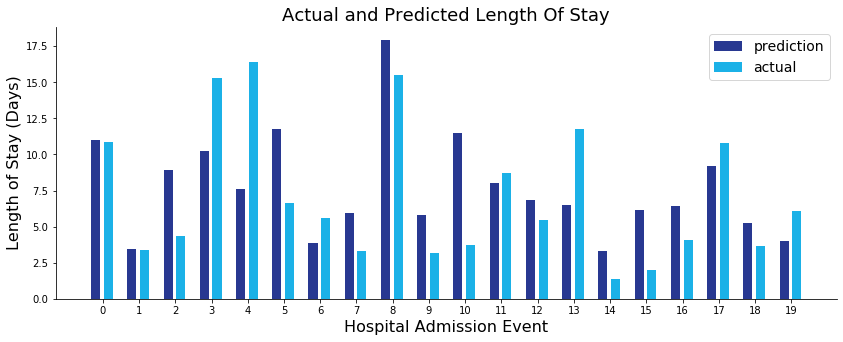

In [77]:
bidmc_deep_blue = '#283891'
bidmc_light_blue = '#1bb1e7ff'

fig, ax = plt.subplots(figsize=(14, 5))
ind = np.arange(0,20)
pad = 0.15
width = 0.35
x1 = range(0,40,2)
x2 = list(np.linspace(.7,38.7, 20))
label_loc = list(np.linspace(.4,38.4, 20))

ax.bar(x1, full_dataset_regression_predictions[:20], color=bidmc_deep_blue, width=0.5, label='prediction')
ax.bar(x2, y_test_fm[:20], color=bidmc_light_blue, width=0.5, label='actual')

plt.title('Actual and Predicted Length Of Stay', fontsize=18)
plt.ylabel('Length of Stay (Days)', fontsize=16)
plt.xlabel('Hospital Admission Event', fontsize=16, ha='center');
plt.legend(fontsize=14)
ax.set_xticks(label_loc)
ax.set_xticklabels(list(range(20)), fontsize=10)
sns.despine()

fig.savefig('actual_vs_predicted_los.png')

## Observing Factor Impact On The Model

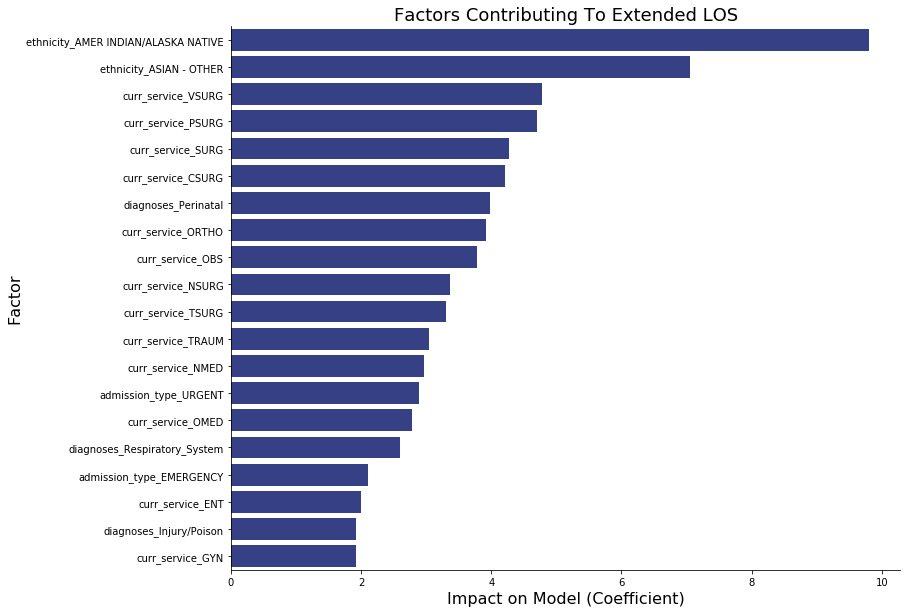

In [78]:
plt.figure(figsize=(12,10))
ethn_los = sns.barplot(x=sorted_col_coef['coef'][:20], y = sorted_col_coef.column[:20], color=bidmc_deep_blue);
    
ethn_los.set_title('Factors Contributing To Extended LOS', fontsize=18)
ethn_los.set_ylabel('Factor', fontsize=16)
ethn_los.set_xlabel('Impact on Model (Coefficient)', fontsize=16);
sns.despine()

plt.savefig('contributing_factors.png')

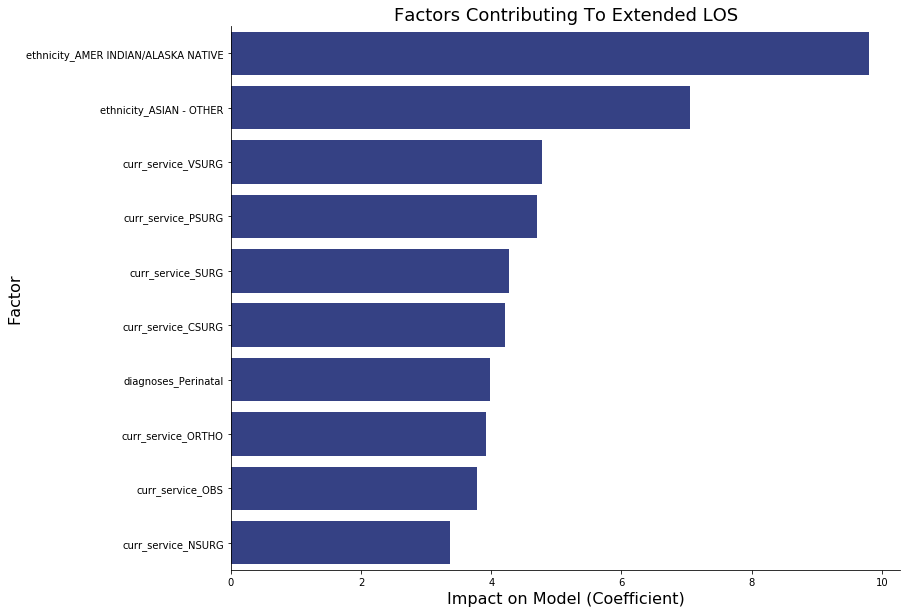

In [79]:
plt.figure(figsize=(12,10))
ethn_los = sns.barplot(x=sorted_col_coef['coef'][:10], y = sorted_col_coef.column[:10], color=bidmc_deep_blue);
    
ethn_los.set_title('Factors Contributing To Extended LOS', fontsize=18)
ethn_los.set_ylabel('Factor', fontsize=16)
ethn_los.set_xlabel('Impact on Model (Coefficient)', fontsize=16);
sns.despine()

plt.savefig('contributing_factors.png')

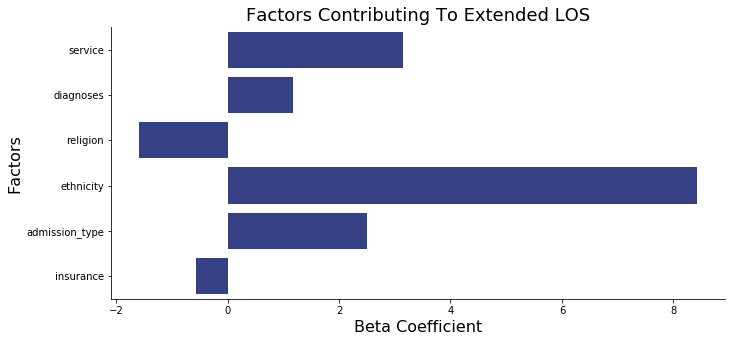

In [80]:
cs = sorted_col_coef[sorted_col_coef['column'].str.contains('curr_serv')]
diag = sorted_col_coef[sorted_col_coef['column'].str.contains('diagnoses')]
religion = sorted_col_coef[sorted_col_coef['column'].str.contains('religion')]
ethnicity = sorted_col_coef[sorted_col_coef['column'].str.contains('ethnicity')]
adm_t = sorted_col_coef[sorted_col_coef['column'].str.contains('admission_type')]
ins = sorted_col_coef[sorted_col_coef['column'].str.contains('insurance')]

cs_m = cs.coef.mean()
diag_m = diag.coef.mean()
religion_m = religion.coef.mean()
ethnicity_m = ethnicity.coef.mean()
adm_t_m = adm_t.coef.mean()
ins_m = ins.coef.mean()

x = [cs_m, diag_m, religion_m, ethnicity_m, adm_t_m, ins_m]
y = ['service', 'diagnoses','religion','ethnicity','admission_type','insurance']

plt.figure(figsize=(11,5))
ethn_los = sns.barplot(x=x, y=y, color=bidmc_deep_blue);
    
ethn_los.set_title('Factors Contributing To Extended LOS', fontsize=18)
ethn_los.set_ylabel('Factors', fontsize=16)
ethn_los.set_xlabel('Beta Coefficient', fontsize=16);
sns.despine()

plt.savefig('contributing_factors.png')